# Infer ***nucleus***, ***cellmask***, and ***cytoplasm*** from a composite image of cytoplasmic organelles
### Alternative workflow: ***"B"*** (an alternative workflow for images with only cytoplasmic organelles, NO **nuclei** or **cell membrane** makers, and more than one cell per field of view)
--------------

## OBJECTIVES
### <input type="checkbox"/> Infer sub-cellular component #1️: ***cytoplasm***
Segment the ***cytoplasm*** of all cell in the image using a composite of multiple organelle markers combined. This mask should be specific to the cytoplasmic area, but will only be a semantic segmentation.

> ###### **Biological relevance: The combination of organelle markers used to create the composite image for the cytoplasm segmentation is based on the assumption that the organelle labels used will "fill up" the entire cytoplasm (not including the nucleus). This is NOT the most accurate method to determine the cell area, but is required in the case where membrane and nuclei markers can not or are not included. This largely depends on the organelle labeles used and the cell type.**
> ###### ***It is important to consider specifics of your system as the cell type and labeling method may differ from the example above.***


### <input type="checkbox"/> Infer sub-cellular component #2️: ***nucleus***
Segment all ***nuclei*** from the inverse of the ***cytoplasm*** mask. Because the organelles used for the composite are cytoplasmic, the nuclei should remain "empty".


### <input type="checkbox"/> Infer sub-cellular component #3️: ***cellmask***
Segment the ***cellmask*** by combining the ***cytoplasm*** and ***nucleus*** masks. To create an instance segmentation of the cellmask, the nuclei will be used as the seeds for the watershed operation. The cell with the highest combined fluorescence intensity will be considered the main cell for analysis and everything else will be discarded. The nuclei and cytoplasm associated to that cell will be selected by masking.

> ###### 📝 **this workflow is optimized for images with multiple fluorescent cells in the field of view**

---------
## **masks_B workflow**
### summary of steps

➡️ **EXTRACTION**
- **`STEP 1`** - Create composite image

    - determine weight to apply to each channel of the intensity image (w# = user input)
    - rescale summed image intensities (rescale = user input)

**PRE-PROCESSING**
- **`STEP 2`** - Rescale and smooth image

    - rescale intensity of composite image (min=0, max=1)
    - median filter (median size = user input)
    - gaussian filter (sigma = user input)

- **`STEP 3`** - Log transform + Scharr edge detection

    - perform a log transformation on the image
    - apply Scharr edge detection filter
    - combine log image and Scharr edge filtered intensity image
 
**CORE PROCESSING**
- **`STEP 4`** - Semantic segmentation of the cytoplasm

    - apply MO thresholding method from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (threshold options = user input)
    - fill holes (hole size = user input)
    - remove small objects (object size = user input)
    - filter method = (method = user input)
    
- **`STEP 5`** - Segmentation of nuclei ‘seeds’ from cytoplasm

    - binary opening of inverted aggregate cytoplasm mask (eroded -> dilated)
    - fill nuclei in aggregate cytoplasm mask (hole size = user input)
    - logical **XOR** of the cytoplasm and the filled in cytoplasm resulting in the nucleus and any artifacts from binary opening (erosion -> dilation)
    - remove small objects (object size = user input)
    
- **`STEP 6`** - Combine nucleus masks and cytoplasm masks

    - logical **OR** of the nucleus and cytoplasm
    - fill gaps (hole size = user input)

**POST-PROCESSING**
- **`STEP 7`** - Label cells based on nuclei 'seeds'; isolate highest intensity

    - perform a masked inverted watershed with the aggregate cellmask segmentation and the nuclei seeds
    - select the label with the highest total intensity

**POST-POST-PROCESSING**
- **`STEP 8`** - Segmentation of single nucleus from cytoplasm; cell mask applied

    - logical **AND** of the cellmask and aggregate cytoplasm mask
    - invert cytoplasm mask and clear border (nucleus mask)
    - fill holes (hole size = user input)
    - remove small objects (object size = user input)

**EXPORT** ➡️
- **`STEP 9`** - Stack masks

    - stack masks in order of nucleus, cellmask and cytoplasm mask

---------
## **IMPORTS**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block loads all of the necessary python packages and functions you will need for this notebook. 

In [5]:
from pathlib import Path
import os
from typing import Union

import numpy as np
import napari
from napari.utils.notebook_display import nbscreenshot

from skimage.segmentation import clear_border #watershed, 
from skimage.morphology import binary_opening#, remove_small_holes, binary_erosion   # function for post-processing (size filter)
from skimage.measure import label

from infer_subc.core.file_io import (read_czi_image,
                                     export_inferred_organelle,
                                     list_image_files,
                                     sample_input)

                                             
from infer_subc.core.img import *
from infer_subc.organelles import non_linear_cellmask_transform

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **LOAD AND READ IN IMAGE FOR PROCESSING**

#### &#x1F6D1; &#x270D; **User Input Required:**

In [ ]:
### USER INPUT REQUIRED ###
# If using the sample data, set cell_type to "astrocyte":
# If not using the sample data, set cell_type to None
sample_data_type = "astrocyte"

# Specify which file you'd like to segment from the img_file_list
test_img_n = 0

# If you are not using the sample data, please edit "USER SPECIFIED" as necessary.
## Define the path to the directory that contains the input image folder.
data_root_path = Path("USER SPECIFIED")

# Specify the file type of your raw data that will be analyzed. Ex) ".czi" or ".tiff"
im_type = "USER SPECIFIED"

## Specify which subfolder that contains the input data and the input data file extension
in_data_path = data_root_path / "USER SPECIFIED"

## Specify the output folder to save the segmentation outputs if.
## If its not already created, the code below will creat it for you
out_data_path = data_root_path / "USER SPECIFIED"

#### &#x1F3C3; **Run code; no user input required**

In [ ]:
# If sample_data_type is set to "astrocyte", then the sample data is used and the directories are set
if sample_data_type != None:
    data_root_path, im_type, in_data_path, out_data_path = sample_input(sample_data_type)

In [4]:
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

img_file_list = list_image_files(in_data_path,im_type)
# pd.set_option('display.max_colwidth', None)
# pd.DataFrame({"Image Name":img_file_list})

In [4]:
test_img_name = img_file_list[test_img_n]

img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

# ***EXTRACTION prototype - masks_B***


## **`STEP 1` - Create composite image**

- determine weight to apply to each channel of the intensity image (w# = user input)
- rescale summed image intensities (rescale = user input)

In [5]:
# Creating a composite image

w0 = 2
w1 = 2
w2 = 3
w3 = 1
w4 = 4
w5 = 2
w6 = 0
w7 = 0
w8 = 0
w9 = 0

rescale = True

struct_img_raw = make_aggregate(img_data,
               weight_ch0= w0,
               weight_ch1= w1,
               weight_ch2= w2,
               weight_ch3= w3,
               weight_ch4= w4,
               weight_ch5= w5,
               weight_ch6= w6,
               weight_ch7= w7,
               weight_ch8= w8,
               weight_ch9= w9,
               rescale = rescale)

# weights = [4,3,1,1,6,6]
# struct_img_raw = weighted_aggregate(img_data, *weights)

# ***PRE-PROCESSING prototype - masks_B***

## **`STEP 2` - Rescale and smooth image**

- rescale intensity of composite image (min=0, max=1)
- median filter (median size = user input)
- gaussian filter (sigma = user input)

> **NOTE**: No smoothing was done here because these test images were already pre-processed.

In [6]:
med_filter_size = 0
gaussian_smoothing_sigma = 0

structure_img_smooth = scale_and_smooth(struct_img_raw,
                                        median_size = med_filter_size, 
                                        gauss_sigma = gaussian_smoothing_sigma)

## **`STEP 3` - Log transform + Scharr edge detection**

- perform a log transformation on the image
- apply Scharr edge detection filter
- combine log image and Scharr edge filtered intensity image

In [7]:
# log scale the image, apply the scharr edge detection filter to logged image, add the two images together
composite_cytomask = non_linear_cellmask_transform(structure_img_smooth)

# ***CORE-PROCESSING prototype - masks_B***

## **`STEP 4` -  Semantic segmentation of the cytoplasm**

- apply MO thresholding method from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (threshold options = user input)

In [8]:
# threshold the composite image after
# log/edge detection then use the MO filter function from aicssegmentation - this applies a global threshold, then a local threshold to produce a semantic segmentation
thresh_method = 'med'
cutoff_size =  200
thresh_adj = 0.914286

bw_cyto = masked_object_thresh(composite_cytomask, 
                          global_method=thresh_method, 
                          cutoff_size=cutoff_size, 
                          local_adjust=thresh_adj)

- fill holes (hole size = user input)
- remove small objects (object size = user input)
- filter method = (method = user input)

> ###### 📝 **the size parameters are by convention defined as one dimensional "width", so the inputs to the functions are _squared_ i.e. raised to the power of 2: `**2` for 2D analysis. For volumetric (3D) analysis this would be _cubed_: `**3`.**

In [9]:
hole_min_width = 0
hole_max_width = 50

small_object_width = 50

fill_filter_method = "slice_by_slice"

cleaned_cyto = fill_and_filter_linear_size(bw_cyto, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size= small_object_width,
                                           method=fill_filter_method)

###### This cell ensures the cytoplasm mask is a boolean

In [10]:
# cytoplasm_mask = label_bool_as_uint16(cleaned_cyto)

cytoplasm_multiple = cleaned_cyto.astype(bool)

Define `_segment_cytoplasm_area` function

In [11]:
def _segment_cytoplasm_area(in_img: np.ndarray, 
                           MO_method: str,
                           MO_cutoff: int,
                           MO_adjust: float,
                           holefill_min: int,
                           holefill_max: int,
                           obj_min_size: int,
                           fill_filter_method: str):
    """ 
    Function for segmenting the cytoplasmic area from a fluorescent image

    Parameters:
    ----------
    in_img: np.ndarray, 
        fluorescence image (single channel, ZYX array) of the cytoplasm to get segmented
    MO_method: str,
        masked object threshold method; options: 'med', 'tri', 'ave'
    MO_cutoff: int,
        object cutoff size for the MO threshold method
    MO_adjust: float,
        adjustment value for the MO threshold method
    holefill_min: int,
        smallest sized hole to fill in the final mask
    holefill_max: int,
        largest sized hole to fill in the final mask
    obj_min_size: int,
        size of the smallest object to be included in the mask; small objects are removed
    fill_filter_method: str
        fill holes and remove small objects in '3D' or 'slice_by_slice'


    """
    # create cytoplasm mask
    bw_cyto = masked_object_thresh(in_img, 
                            global_method=MO_method, 
                            cutoff_size=MO_cutoff, 
                            local_adjust=MO_adjust)
    
    # fill holes and filter small objects from the raw mask
    cleaned_cyto = fill_and_filter_linear_size(bw_cyto, 
                                            hole_min=holefill_min, 
                                            hole_max=holefill_max, 
                                            min_size= obj_min_size,
                                            method=fill_filter_method)
    
    # create a boolean mask
    cyto_semantic_seg = cleaned_cyto.astype(bool)

    return cyto_semantic_seg

Run `_segment_cytoplasm_area` function

In [12]:
thresh_method = 'med'
cutoff_size =  200
thresh_adj = 0.914286
hole_min_width = 0
hole_max_width = 50

small_object_width = 50

fill_filter_method = "slice_by_slice"

test_cyto_masks = _segment_cytoplasm_area(composite_cytomask,
                                          MO_method=thresh_method,
                                          MO_cutoff=cutoff_size,
                                          MO_adjust=thresh_adj,
                                          holefill_max=hole_max_width,
                                          holefill_min=hole_min_width,
                                          obj_min_size=small_object_width,
                                          fill_filter_method=fill_filter_method)

# np.array_equal(test_cyto_masks, cytoplasm_multiple)

## **`STEP 5` - Segmentation of nuclei ‘seeds’ from cytoplasm**

- binary opening of inverted aggregate cytoplasm mask (erosion -> dilation)

In [13]:
cytoplasm_inverse = 1 - test_cyto_masks

cytoplasm_inv_opened = binary_opening(cytoplasm_inverse, footprint=np.ones([3,3,3]))

- fill nuclei in aggregate cytoplasm mask (hole size = user input)
- logical **XOR** of the cytoplasm and the filled in cytoplasm resulting in the nucleus and any artifacts from binary opening

In [14]:
max_nuc_width = 350

nuc_removed = fill_and_filter_linear_size(cytoplasm_inv_opened, 
                                          hole_max=0, 
                                          hole_min=0, 
                                          min_size=max_nuc_width, 
                                          method='3D')

nuc_objs = np.logical_xor(cytoplasm_inv_opened, nuc_removed)

- remove small objects (object size = user input)

In [15]:
hole_max = 0
hole_min = 0
min_size = 15

nuc_cleaned = fill_and_filter_linear_size(nuc_objs, 
                                          hole_max=hole_max, 
                                          hole_min=hole_min, 
                                          min_size=min_size, 
                                          method='3D')

###### Create labels for the nuclei seeds that will be used during the watershedding algorithm

In [16]:
# create instance segmentation based on connectivity
nuc_labels = label(nuc_cleaned).astype(np.uint16)

Define `_segment_nuclei_seeds` function

In [17]:
def _segment_nuclei_seeds(cyto_seg: np.ndarray,
                          max_nuclei_width: int,
                          filter_small_objs: int):
    """ 
    
    
    """
    # create the inverse of the cytoplasm and increase likelihood for object separation with binary opening
    cytoplasm_inverse = 1 - cyto_seg
    cytoplasm_inv_opened = binary_opening(cytoplasm_inverse, footprint=np.ones([3,3,3]))

    # isolate the nuclei objects that fill be used as seeds for watershed
    # these aren't exactly the inverse of the cytoplasm because of the binary opening
    nuc_removed = fill_and_filter_linear_size(cytoplasm_inv_opened, 
                                            hole_max=0, 
                                            hole_min=0, 
                                            min_size=max_nuclei_width, 
                                            method='3D')

    nuc_objs = np.logical_xor(cytoplasm_inv_opened, nuc_removed)

    # remove an small debris leftover that aren't the correct size for nuclei
    nuc_cleaned = fill_and_filter_linear_size(nuc_objs, 
                                            hole_max=0, 
                                            hole_min=0, 
                                            min_size=filter_small_objs, 
                                            method='3D')
    

    return label(nuc_cleaned).astype(np.uint16)

Run `_segment_nuclei_seeds` function

In [18]:
test_nuc_labels = _segment_nuclei_seeds(test_cyto_masks, max_nuclei_width=350, filter_small_objs=10)

np.array_equal(nuc_labels, test_nuc_labels)

False

## **`STEP 6` - Combine nucleus masks and cytoplasm masks**

- logical **OR** of the nucleus and cytoplasm

In [19]:
cells = np.logical_or(test_nuc_labels, test_cyto_masks)

- fill gaps (hole size = user input)

In [20]:
cell_multiple = fill_and_filter_linear_size(cells, 
                                            hole_min=0,
                                            hole_max=20,
                                            min_size=0,
                                            method='3D')

Define `_combine_cytoplasm_and_nuclei` function

In [21]:
def _combine_cytoplasm_and_nuclei(cyto_seg: np.ndarray,
                                  nuc_seg: np.ndarray,
                                  fillhole_max: int):
    """
    Function to combine the the cytoplasm and nuclei segmentations to produce the entire cell mask.

    Parameters:
    ----------
    cyto_seg: np.ndarray,
        image containing the cytoplasm segmentation
    nuc_seg: np.ndarray,
        image containing the nuclei segmentation
    fillhole_max: int
        size of the gaps between the nuclei and cytoplasm (usually small)
    """ 
    
    cells = np.logical_or(cyto_seg.astype(bool), nuc_seg.astype(bool))

    cell_multiple = fill_and_filter_linear_size(cells, 
                                                hole_min=0,
                                                hole_max=fillhole_max,
                                                min_size=0,
                                                method='3D')
    
    cell_area = cell_multiple.astype(bool)

    return cell_area

Run `_combine_cytoplasm_and_nuclei` function

In [22]:
test_cell_area = _combine_cytoplasm_and_nuclei(test_cyto_masks, test_nuc_labels, 20)

np.array_equal(cell_multiple, test_cell_area)

True

# ***POST-PROCESSING prototype - masks_B***

## **`STEP 7` - Label cells based on nuclei 'seeds'; isolate highest intensity**

- perform a masked inverted watershed with the aggregate cellmask segmentation and the nuclei seeds

In [23]:
cell_labels = masked_inverted_watershed(test_cell_area, markers=nuc_labels, mask=test_cell_area, method='3D')

- select the label with the highest total intensity (collect labels)

In [24]:
# determine the brightest cell
target_labels = None
labels_in = cell_labels

if target_labels is None:
    all_labels = np.unique(cell_labels)[1:]
else:
    all_labels = np.unique(target_labels)[1:]

all_labels

# # determine the largest cell
# cell_IDs = np.unique(cell_labels)[1:]

# dict = {}
# for obj in cell_IDs:
#     pxlcnt = np.sum(cell_labels==obj)
#     dict[obj] = pxlcnt

# largest_ID = max(dict, key=dict.get)
# largest_cell = cell_labels == largest_ID

# largest_ID, dict

array([1])

- select the label with the highest total intensity (create composites from normalized channels)

In [25]:
# create a composite from each intensity channel after they have been min-max normalized
norm_channels = [(min_max_intensity_normalization(img_data[c])) for c in range(len(img_data))]
normed_signal = np.stack(norm_channels, axis=0)

normed_composite = normed_signal.sum(axis=0)

np.max(normed_signal), normed_signal.shape, normed_composite.shape

(1.0, (6, 18, 1688, 1688), (18, 1688, 1688))

- select the label with the highest total intensity (select cell with highest intensity)

In [26]:
# find the cell mask that has the highest intensity
total_signal = [normed_composite[labels_in == label].sum() for label in all_labels]

keep_label = all_labels[np.argmax(total_signal)]

good_cell = cell_labels == keep_label

Define `_select_highest_intensity_cell` function

In [27]:
def _select_highest_intensity_cell(raw_image: np.ndarray,
                                   cell_seg: np.ndarray,
                                   nuc_seg: np.ndarray):
    """ 
    Create an instance segmentation of the cell area using a watershed operation based on nuclei seeds.
    Then, select the cell with the highest combined organelle intensity.

    Parameters:
    ----------
    raw_image: np.ndarray,
        gray scale 3D multi-channel numpy array (CZYX)
    cell_seg: np.ndarray,
        binary cell segmentation with multiple cells in the FOV
    nuc_seg: np.ndarray,
        labeled nuclei segmentation with each nuclei having a different ID number (e.g., the result of the skimage label() function)
    labels_to_consider: Union(list, None)
        a list of labels that should be considered when determining the highest intensity. Default is None which utilizes all possible labels in the cell image
        
    Output
    ----------
    good_cell: np.ndarray  
        a binary image of the single cell with the highest total fluorescence intensity
    """
    # instance segmentation of cell area with watershed function
    cell_labels = masked_inverted_watershed(cell_seg, markers=nuc_seg, mask=cell_seg, method='3D')

    # create composite of all fluorescence channels after min-max normalization
    norm_channels = [(min_max_intensity_normalization(raw_image[c])) for c in range(len(raw_image))]
    normed_signal = np.stack(norm_channels, axis=0)
    normed_composite = normed_signal.sum(axis=0)

    # list of cell IDs to measure intensity of
    all_labels = np.unique(cell_labels)[1:]

    # measure total intensity in each cell from the ID list
    total_signal = [normed_composite[cell_labels == label].sum() for label in all_labels]

    # select the cell with the highest total intensity
    keep_label = all_labels[np.argmax(total_signal)]
    good_cell = cell_labels == keep_label

    return good_cell

Run `_select_highest_intensity_cell` function

In [28]:
test_good_cell = _select_highest_intensity_cell(img_data, test_cell_area, test_nuc_labels)

np.array_equal(good_cell, test_good_cell)

False

# ***POST-POST-PROCESSING prototype - masks_B***

## **`STEP 8` - Segmentation of single nucleus from cytoplasm; cell mask applied**

- logical **AND** of the cellmask and aggregate cytoplasm mask

In [29]:
good_cyto = apply_mask(test_cyto_masks, good_cell).astype(bool)

- invert cytoplasm mask and clear border (nucleus mask)
- fill holes (hole size = user input)
- remove small objects (object size = user input)

In [30]:
good_cyto_inverse = 1 - good_cyto

nuc_single = clear_border(good_cyto_inverse)

good_nuc = fill_and_filter_linear_size(nuc_single,
                                       hole_min=0,
                                       hole_max=0,
                                       min_size=10,
                                       method='3D').astype(bool)

Define `_mask_cytoplasm_nuclei` function

In [31]:
def _mask_cytoplasm_nuclei(cellmask: np.ndarray,
                           cyto_seg: np.ndarray,
                           small_obj_size: int):
    """ 
    mask the cytoplasm with the cell mask to isolate the cytoplasmic area of intereste.
    create a single nuclei segmentation from the inverse of the cytoplas (no binary opening)

    Parameters:
    ----------
    cellmask: 
        binary segmentation of a single cell
    cyto_seg:
        semantic segmentation of cytoplasm from multiple cells in an image
    small_obj_size:
        size of small objects to be removed from the final nucleus segmentation image
    """

    good_cyto = apply_mask(cyto_seg, cellmask).astype(bool)

    good_cyto_inverse = 1 - good_cyto

    nuc_single = clear_border(good_cyto_inverse)

    good_nuc = fill_and_filter_linear_size(nuc_single,
                                        hole_min=0,
                                        hole_max=0, 
                                        min_size=small_obj_size,
                                        method='3D')
    
    return good_nuc, good_cyto

In [32]:
### Old version that returned a stack instead

# def _mask_cytoplasm_nuclei(cellmask: np.ndarray,
#                            cyto_seg: np.ndarray,
#                            small_obj_size: int):
#     """ 
#     mask the cytoplasm with the cell mask to isolate the cytoplasmic area of intereste.
#     create a single nuclei segmentation from the inverse of the cytoplas (no binary opening)

#     Parameters:
#     ----------
#     cellmask: 
#         binary segmentation of a single cell
#     cyto_seg:
#         semantic segmentation of cytoplasm from multiple cells in an image
#     small_obj_size:
#         size of small objects to be removed from the final nucleus segmentation image
#     """

#     good_cyto = apply_mask(cyto_seg, cellmask).astype(bool)

#     good_cyto_inverse = 1 - good_cyto

#     nuc_single = clear_border(good_cyto_inverse)

#     good_nuc = fill_and_filter_linear_size(nuc_single,
#                                         hole_min=0,
#                                         hole_max=0, 
#                                         min_size=small_obj_size,
#                                         method='3D')
    
#     stack = stack_masks(nuc_mask=good_nuc, cellmask=cellmask, cyto_mask=good_cyto)
    
#     return stack

Run `_mask_cytoplasm_nuclei` function

In [33]:
test_good_nuc, test_good_cyto = _mask_cytoplasm_nuclei(good_cell, test_cyto_masks, 10)

np.array_equal(test_good_cyto, good_cyto), np.array_equal(test_good_nuc, good_nuc)

(True, True)

In [34]:
# test_good_nuc, test_good_cell, test_good_cyto = _mask_cytoplasm_nuclei(good_cell, test_cyto_masks, 10)

# np.array_equal(test_good_cyto, good_cyto), np.array_equal(test_good_nuc, good_nuc)

# ***EXPORT prototype - masks_B***

## **`STEP 9` - Stack masks**

- stack masks in order of nucleus, cellmask and cytoplasm mask

In [35]:
stack = stack_masks(nuc_mask=test_good_nuc, cellmask=test_good_cell, cyto_mask=test_good_cyto)

Export `masks_B` file to output folder

In [36]:
out_file_n = export_inferred_organelle(stack, "masks_B", meta_dict, out_data_path)

saved file: 05052022_astro_control_2_Linear unmixing_0_cmle.ome-masks_B


#### &#x1F6D1; &#x270D; **User Input Required:**

In [ ]:
## When using the sample data in part 2, quantification is carried out on both the neuron and astrocyte data through
## batch processing. to_batch = True copies the segmentation to the batch processing file location in addition to the
## segmentation folder.

to_batch = True

#### &#x1F3C3; **Run code; no user input required**

In [ ]:
if to_batch and sample_data_type == 'astrocyte':
    out_file_b = export_inferred_organelle(stack, "masks", meta_dict, Path(os.getcwd()).parents[1] / "sample_data" /  "batch_example" / "seg")

## **Visualize `nucleus`, `cellmask` and `cytoplasm`**

In [38]:
viewer_masks_B = napari.Viewer(title = "masks_B",
                           ndisplay=3)
viewer_masks_B.grid.enabled = True

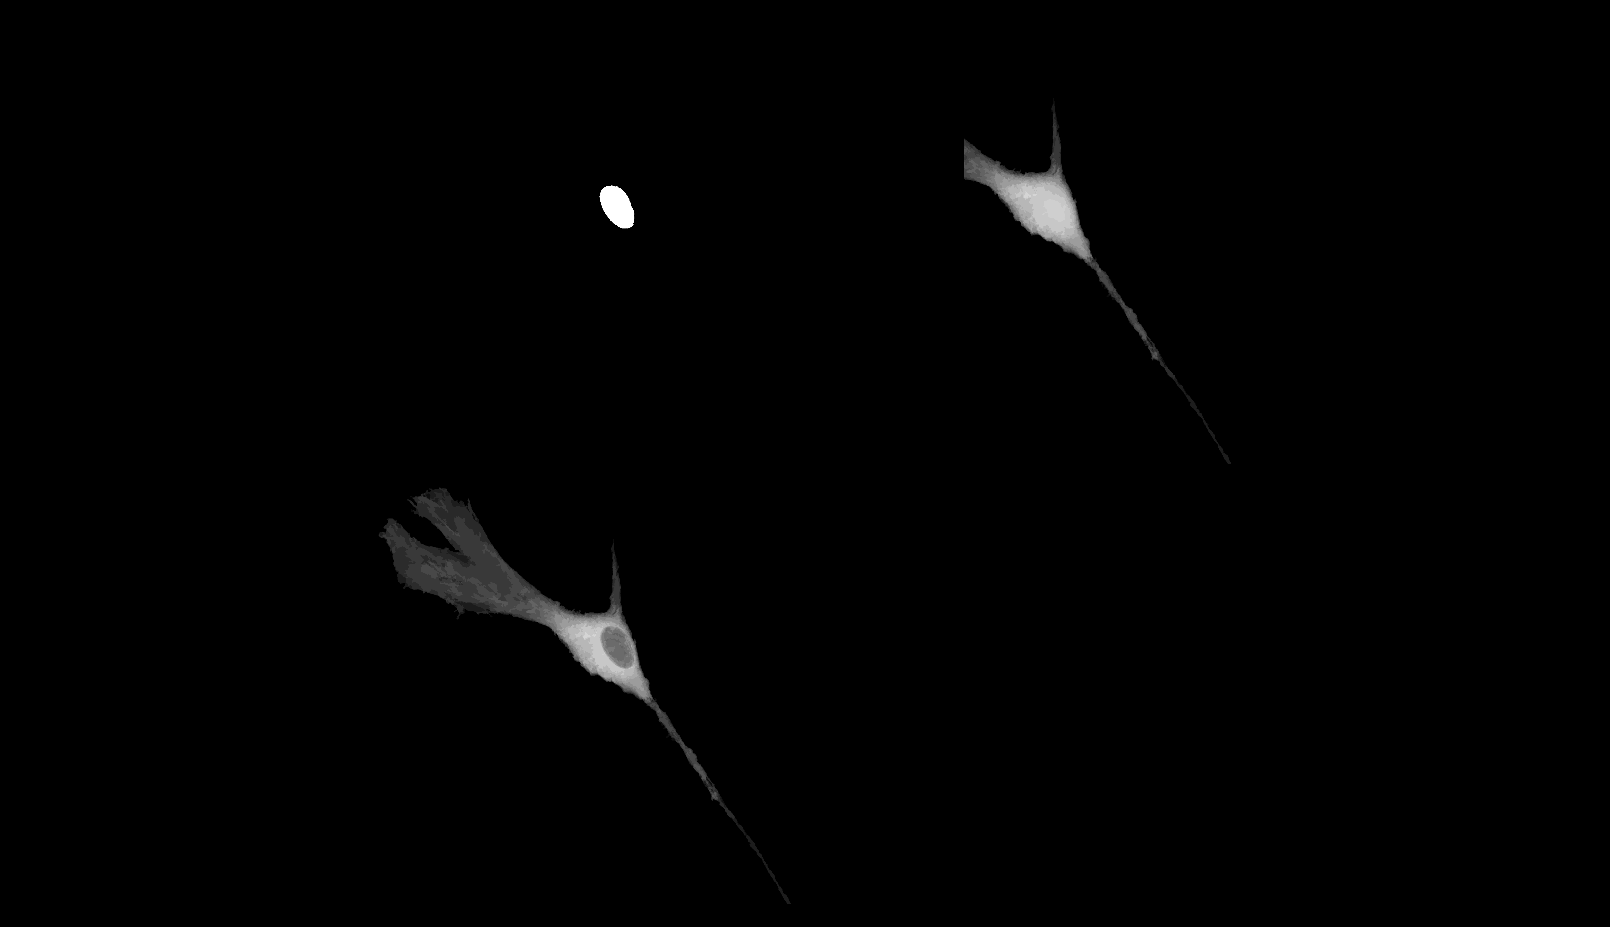

In [39]:
viewer_masks_B.add_image(stack[2].astype(bool),
                      scale = scale,
                      name = 'Cytoplasm',
                      rendering = 'average')

viewer_masks_B.add_image(stack[1].astype(bool),
                      scale = scale,
                      name = 'Cellmask',
                      rendering = 'average')

viewer_masks_B.add_image(stack[0].astype(bool),
                      scale = scale,
                      name = 'Nucleus')

viewer_masks_B.reset_view()

nbscreenshot(viewer_masks_B,
             canvas_only = True)

-------------
### NEXT: INFER LYSOSOME

proceed to [1.2_infer_lysosome.ipynb](./1.2_infer_lysosome.ipynb)